# 1. Import các thư viện

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# 2. Load Dataset

In [4]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding="ISO-8859-1")

In [5]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


# 3. Tiền xử lý dữ liệu cũ

# 3.1. Xử lý giá trị bị thiếu

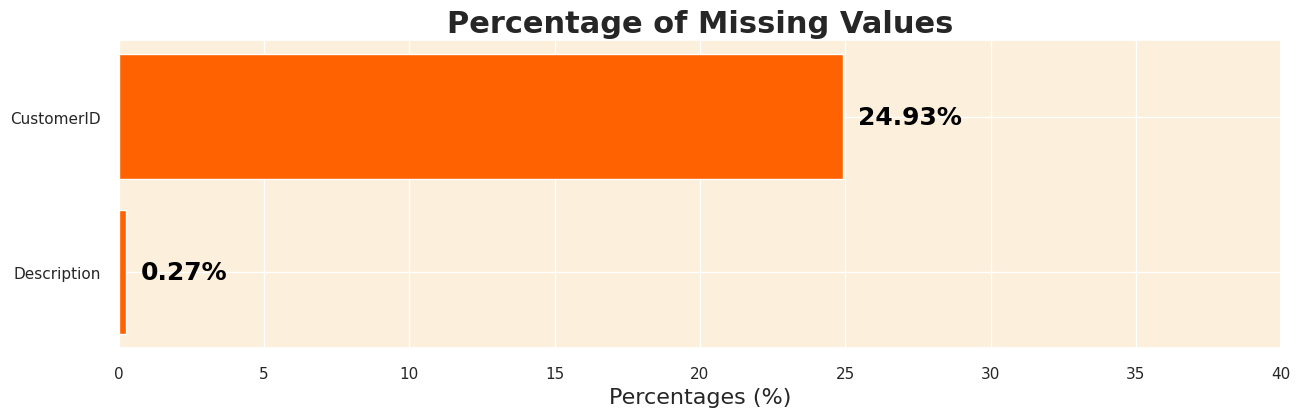

In [9]:
#Tính toán giá trị bị thiếu và biểu diễn trên biểu đồ cột
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')
ax.set_xlim([0, 40])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [10]:
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [11]:
df = df.dropna(subset=['CustomerID', 'Description'])

In [12]:
df.isnull().sum().sum()

0

# 3.2. Xử lý giá trị trùng lặp

In [13]:
#Lấy ra các giá trị bị trùng lặp
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [14]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [15]:
df.shape[0]

401604

# 3.3. Các giao dịch bị hủy

In [16]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [17]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


# 3.4. Các StockCode bất thường

In [18]:
#Lấy ra các StockCode duy nhất
unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


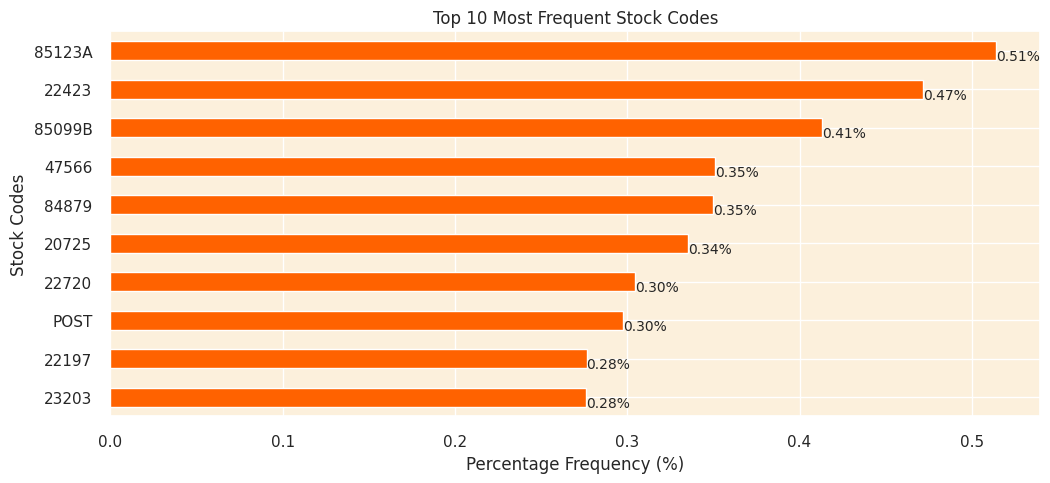

In [19]:
#Tìm ra top 10 StockCode sử dụng nhiều nhất
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

#Biểu diễn lên biểu đồ
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [20]:
# Tìm các giá trị số trong các StockCode
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [21]:
#Tìm các StockCode có 0 hoặc 1 số
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [22]:
#Tính tỉ lệ của các StockCode này
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [23]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [24]:
df.shape[0]

399689

# 3.5. Làm sạch cột Description

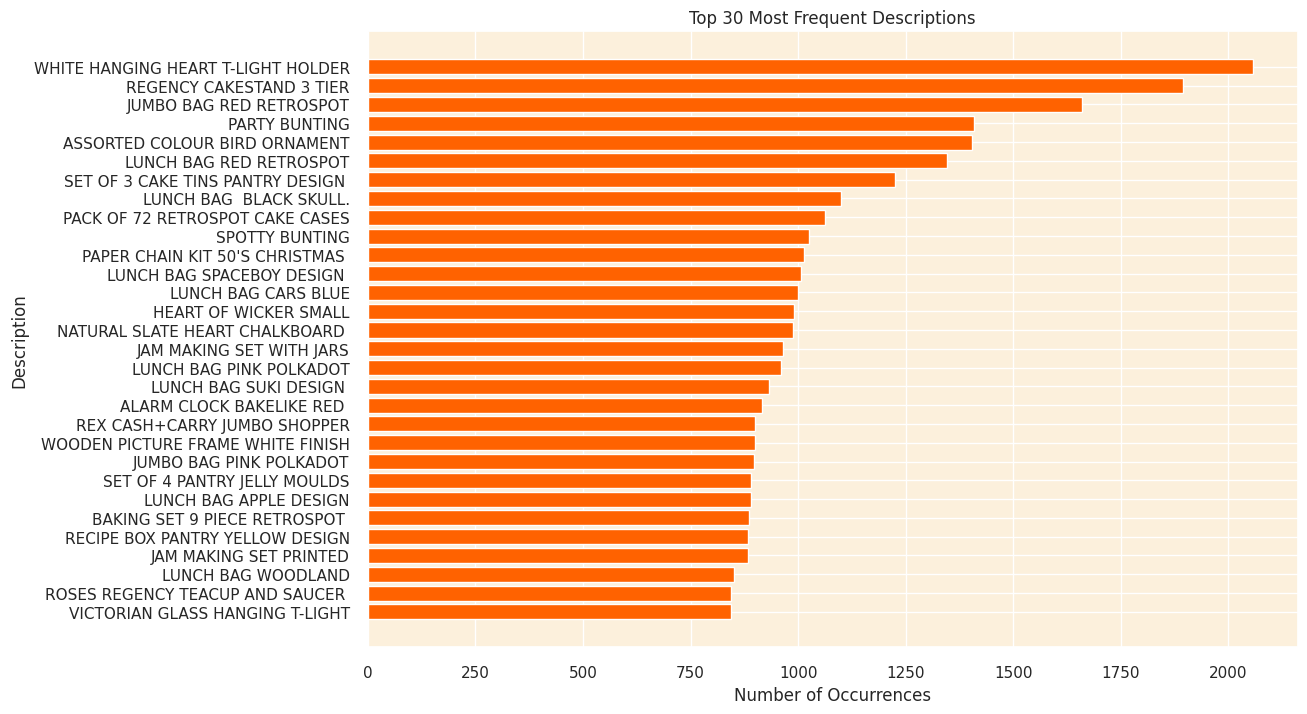

In [25]:
#Count các giá trị description
description_counts = df['Description'].value_counts()

# Lấy top 30
top_30_descriptions = description_counts[:30]

# Biểu diễn lên biểu đồ
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')
plt.show()

In [26]:
# Tìm các Description có lower case
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [27]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Tính tỉ lệ của các description bị loại bỏ
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Loại bỏ các hàng có chứa service_related_descriptions
df = df[~df['Description'].isin(service_related_descriptions)]

# Chuẩn hóa tất cả về upper case
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [28]:
df.shape[0]

399606

# 3.6. UnitPrice = 0

In [29]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [30]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [31]:
df = df[df['UnitPrice'] > 0]

In [32]:
df.reset_index(drop=True, inplace=True)

In [33]:
df.shape[0]

399573

# 4. Tạo ra các thuộc tính mới

# 4.1. Days Since Last Purchase

In [34]:
#CHuyển invoiceDate sang datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Lấy ngày
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Tìm giao dịch gần nhất
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Tìm giao dịch gần nhất trong cả dataset
most_recent_date = df['InvoiceDay'].max()

# Chuyển qua dateTime để thực hiện phép trừ
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

#Bỏ cột InvoiceDay
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [35]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


# 4.2. Total Transactions và Total Products Purchased

In [36]:
# Tính tổng giao dịch được thực hiện bởi khách hàng
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Tính toán tổng số sản phẩm được mua theo mỗi khách hàng
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge các cột mới vào
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


# 4.3. Total Spend, Average Transaction Value

In [37]:
# Tính tổng tiền của mối khách hàng bằng cách lấy số lượng mua * giá tiền của từng sản phẩm
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Tính giá trung bình của các giao dịch
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Thêm hai cột mới vào
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


# 4.4. Unique Products Purchased

In [38]:
# Tính tổng số loại sản phẩm khách hàng mua được
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Thêm cột mới vào bảng
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


# 4.5. Average Days Between Purchases, Favorite Shopping Day, Favorite Shopping Hour

In [39]:
# Lấy ra ngày trong tuần và giờ mua hàng 
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

#Tính số ngày trung bình giữa các lần mua hàng liên tiếp
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Tìm ngày mua sắm yêu thích trong tuần
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Tùm giờ mua sắm yêu thích
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Thêm cột vào dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


# 4.6. Khách hàng có ở Anh không?

In [40]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

In [41]:
# Nhóm theo CustomerID và Quốc gia để lấy số lượng giao dịch theo quốc gia cho mỗi khách hàn
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Lấy quốc gia có số lượng giao dịch tối đa cho mỗi khách hàng (trong trường hợp một khách hàng có giao dịch từ nhiều quốc gia)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Tạo một cột nhị phân cho biết khách hàng có đến từ Vương quốc Anh hay không
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Kết hợp 
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [42]:
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

# 4.7. Cancellation Frequency và Cancellation Rate

In [43]:
# Tính tổng số giao dịch được thực hiện bởi mỗi khách hàng
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

#Tính toán số lượng giao dịch bị hủy của mỗi khách hàng

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Hợp nhất dữ liệu Tần suất hủy vào khung dữ liệu customer_data
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Thay thế giá trị NaN bằng 0 (đối với khách hàng chưa hủy bất kỳ giao dịch nào)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Tính toán tỉ lệ hủy đơn hàng
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


# 4.8. Monthly_Spending_Mean, Monthly_Spending_Std, Spending_Trend

In [44]:
# Trích xuất tháng và năm từ InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Tính toán chi tiêu hàng tháng cho mỗi khách hàng
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Tính toán các mẫu mua theo mùa: Chúng tôi sử dụng tần suất hàng tháng làm đại diện cho các mẫu mua theo mùa
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Thay thế giá trị NaN trong Monthly_Spending_Std bằng 0, ngụ ý không có sự thay đổi đối với khách hàng có tháng giao dịch duy nhất
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Tính toán xu hướng mua hàng 
# Sử dụng độ dốc của đường xu hướng tuyến tính phù hợp với chi tiêu của khách hàng theo thời gian như một chỉ báo về xu hướng chi tiêu
def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

#Áp dụng hàm calculate_trend để tìm xu hướng chi tiêu cho từng khách hàng
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Kết hợp
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [45]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()

In [46]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [47]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

# 5. Giá trị ngoại lai

In [48]:
model = IsolationForest(contamination=0.05, random_state=0)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


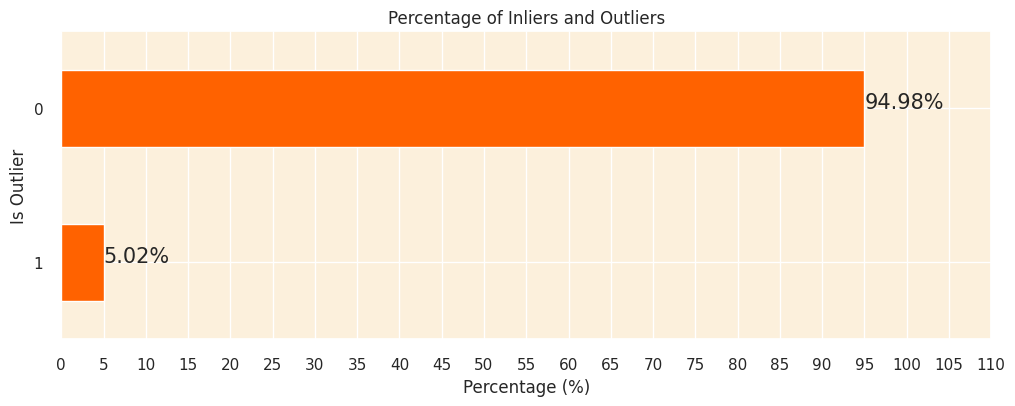

In [49]:
# Tính toán tỉ lệ của giá trị ngoại lai và còn lại
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Vẽ biểu đồ phần trăm các giá trị nội và ngoại tại
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [50]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [51]:
customer_data_cleaned.shape[0]

4067

# 6. Phân tích tương quan

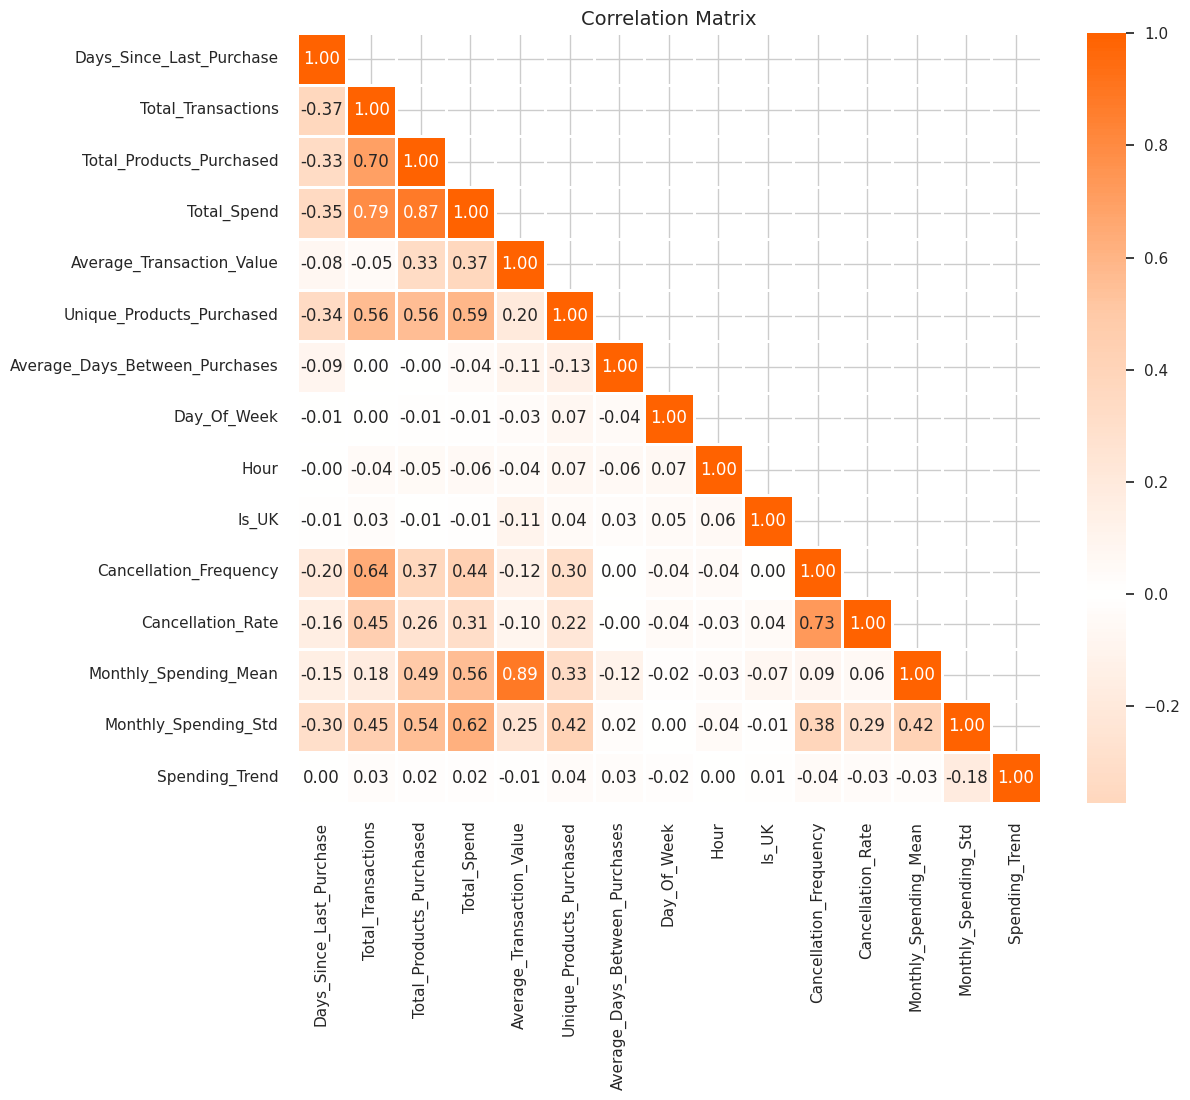

In [52]:
sns.set_style('whitegrid')
# Tính toán ma trận tương quan loại trừ cột 'CustomerID'
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Tạo mask để chỉ show ma trận tam giác dưới vì ma trận tương quan này đối xứng qua đường chéo chính
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

# 7. Chuấn hóa dữ liệu

In [53]:
scaler = StandardScaler()
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)
customer_data_scaled = customer_data_cleaned.copy()
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


# 8. Giảm chiều dữ liệu

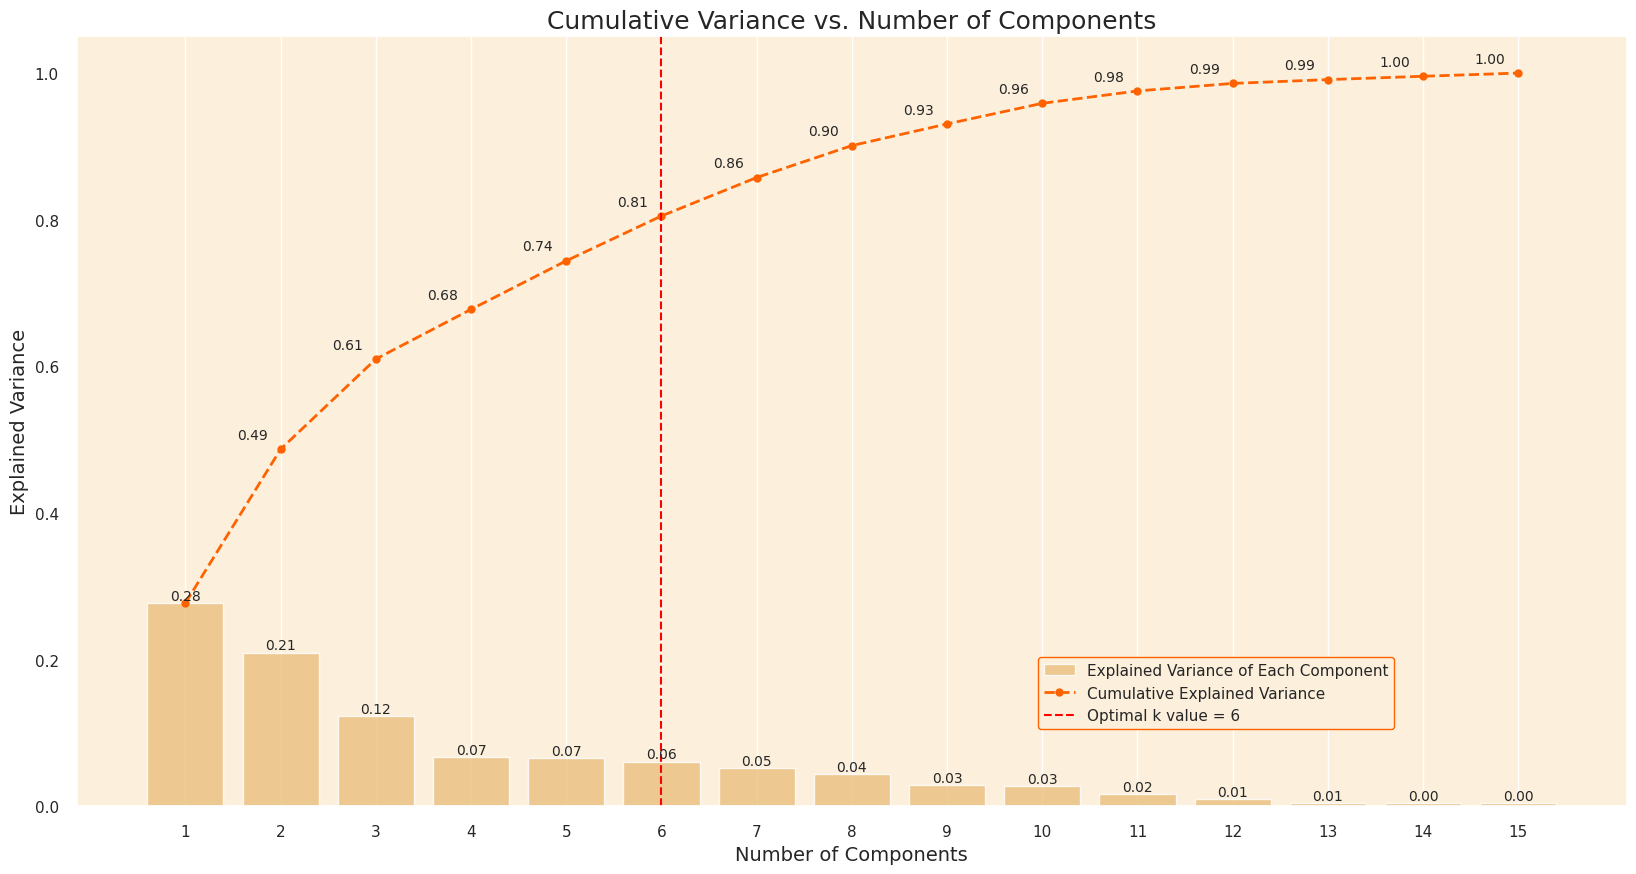

In [54]:
# Đặt CustomerID làm cột chỉ mục
customer_data_scaled.set_index('CustomerID', inplace=True)

# áp dụng PCA
pca = PCA().fit(customer_data_scaled)

# Tính tổng tích lũy của phương sai đã giải thích
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

#Đặt giá trị k tối ưu 
optimal_k = 6
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Vẽ biểu đồ phương sai tích lũy được giải thích so với số lượng thành phần
plt.figure(figsize=(20, 10))
# Biểu đồ thanh cho sự thay đổi được giải thích của từng thành phần
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Biểu đồ đường cho tổng phương sai giải thích được
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Hiển thị các giá trị phương sai cho cả hai biểu đồ trên các ô
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [55]:
pca = PCA(n_components=6)
customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])
customer_data_pca.index = customer_data_scaled.index

In [56]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


In [57]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


# 9. K-means

# 9.1. Biểu đồ elbow

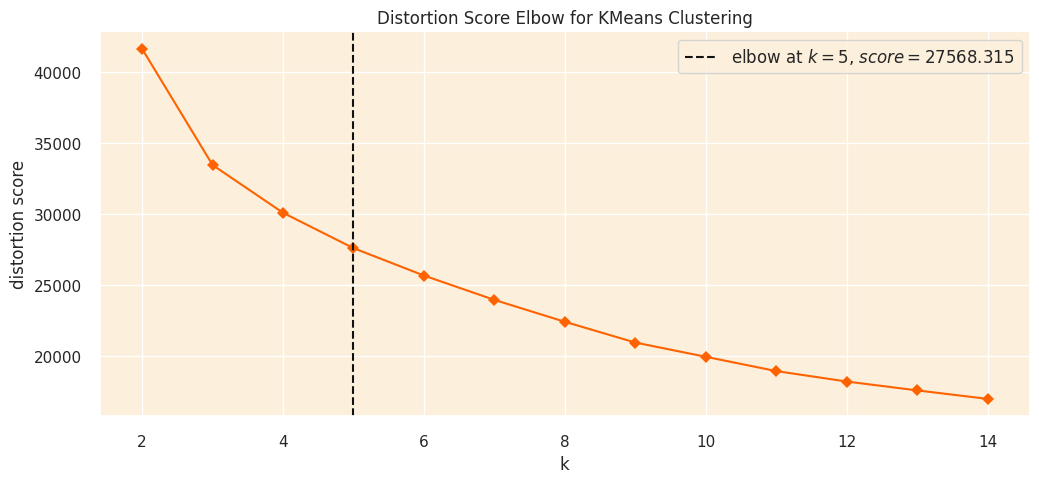

In [58]:
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
sns.set_palette(['#ff6200'])

# Khởi tạo mô hình cụm với các tham số được chỉ định
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)
fig, ax = plt.subplots(figsize=(12, 5))

# Khởi tạo KElbowVisualizer với mô hình và phạm vi giá trị k và vô hiệu hóa biểu đồ thời gian
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)
visualizer.fit(customer_data_pca)
visualizer.show();

# 9.2. Elbow cho KMedoids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.6 MB/s eta 0:00:00


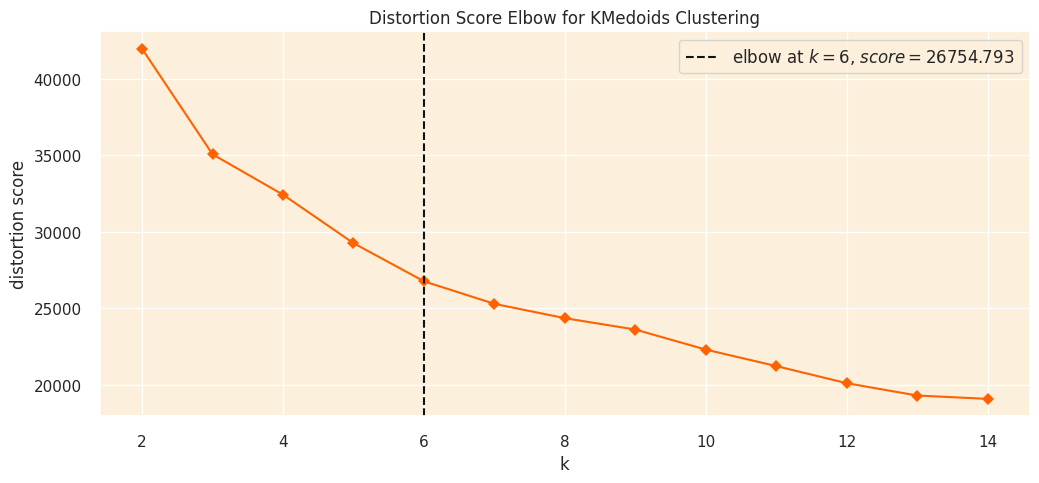

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
sns.set_palette(['#ff6200'])
km1 = KMedoids(init='k-medoids++', max_iter=100, random_state=0)
fig, ax = plt.subplots(figsize=(12, 5))
visualizer1 = KElbowVisualizer(km1, k=(2, 15), timings=False, ax=ax)
visualizer1.fit(customer_data_pca)
visualizer1.show()

# 9.3. Silhouette

In [60]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    plt.figure(figsize=figsize)

    # Tạo lưới với (stop_k - start_k + 1) hàng và 2 cột
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Gán plot đầu tiên cho hàng đầu tiên và cả hai cột
    first_plot = plt.subplot(grid[0, :])

    # Đồ thị đầu tiên: Điểm số Silhouette cho các giá trị k khác nhau
    sns.set_palette(['darkorange'])

    silhouette_scores = []
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # thêm giá trị k cho biểu đồ tiếp theo
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Biểu đồ thứ hai (sub plot): Biểu đồ hình bóng cho mỗi giá trị k
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Gán các ô cho hàng thứ hai, thứ ba và thứ tư
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Thêm điểm Silhouette vào
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

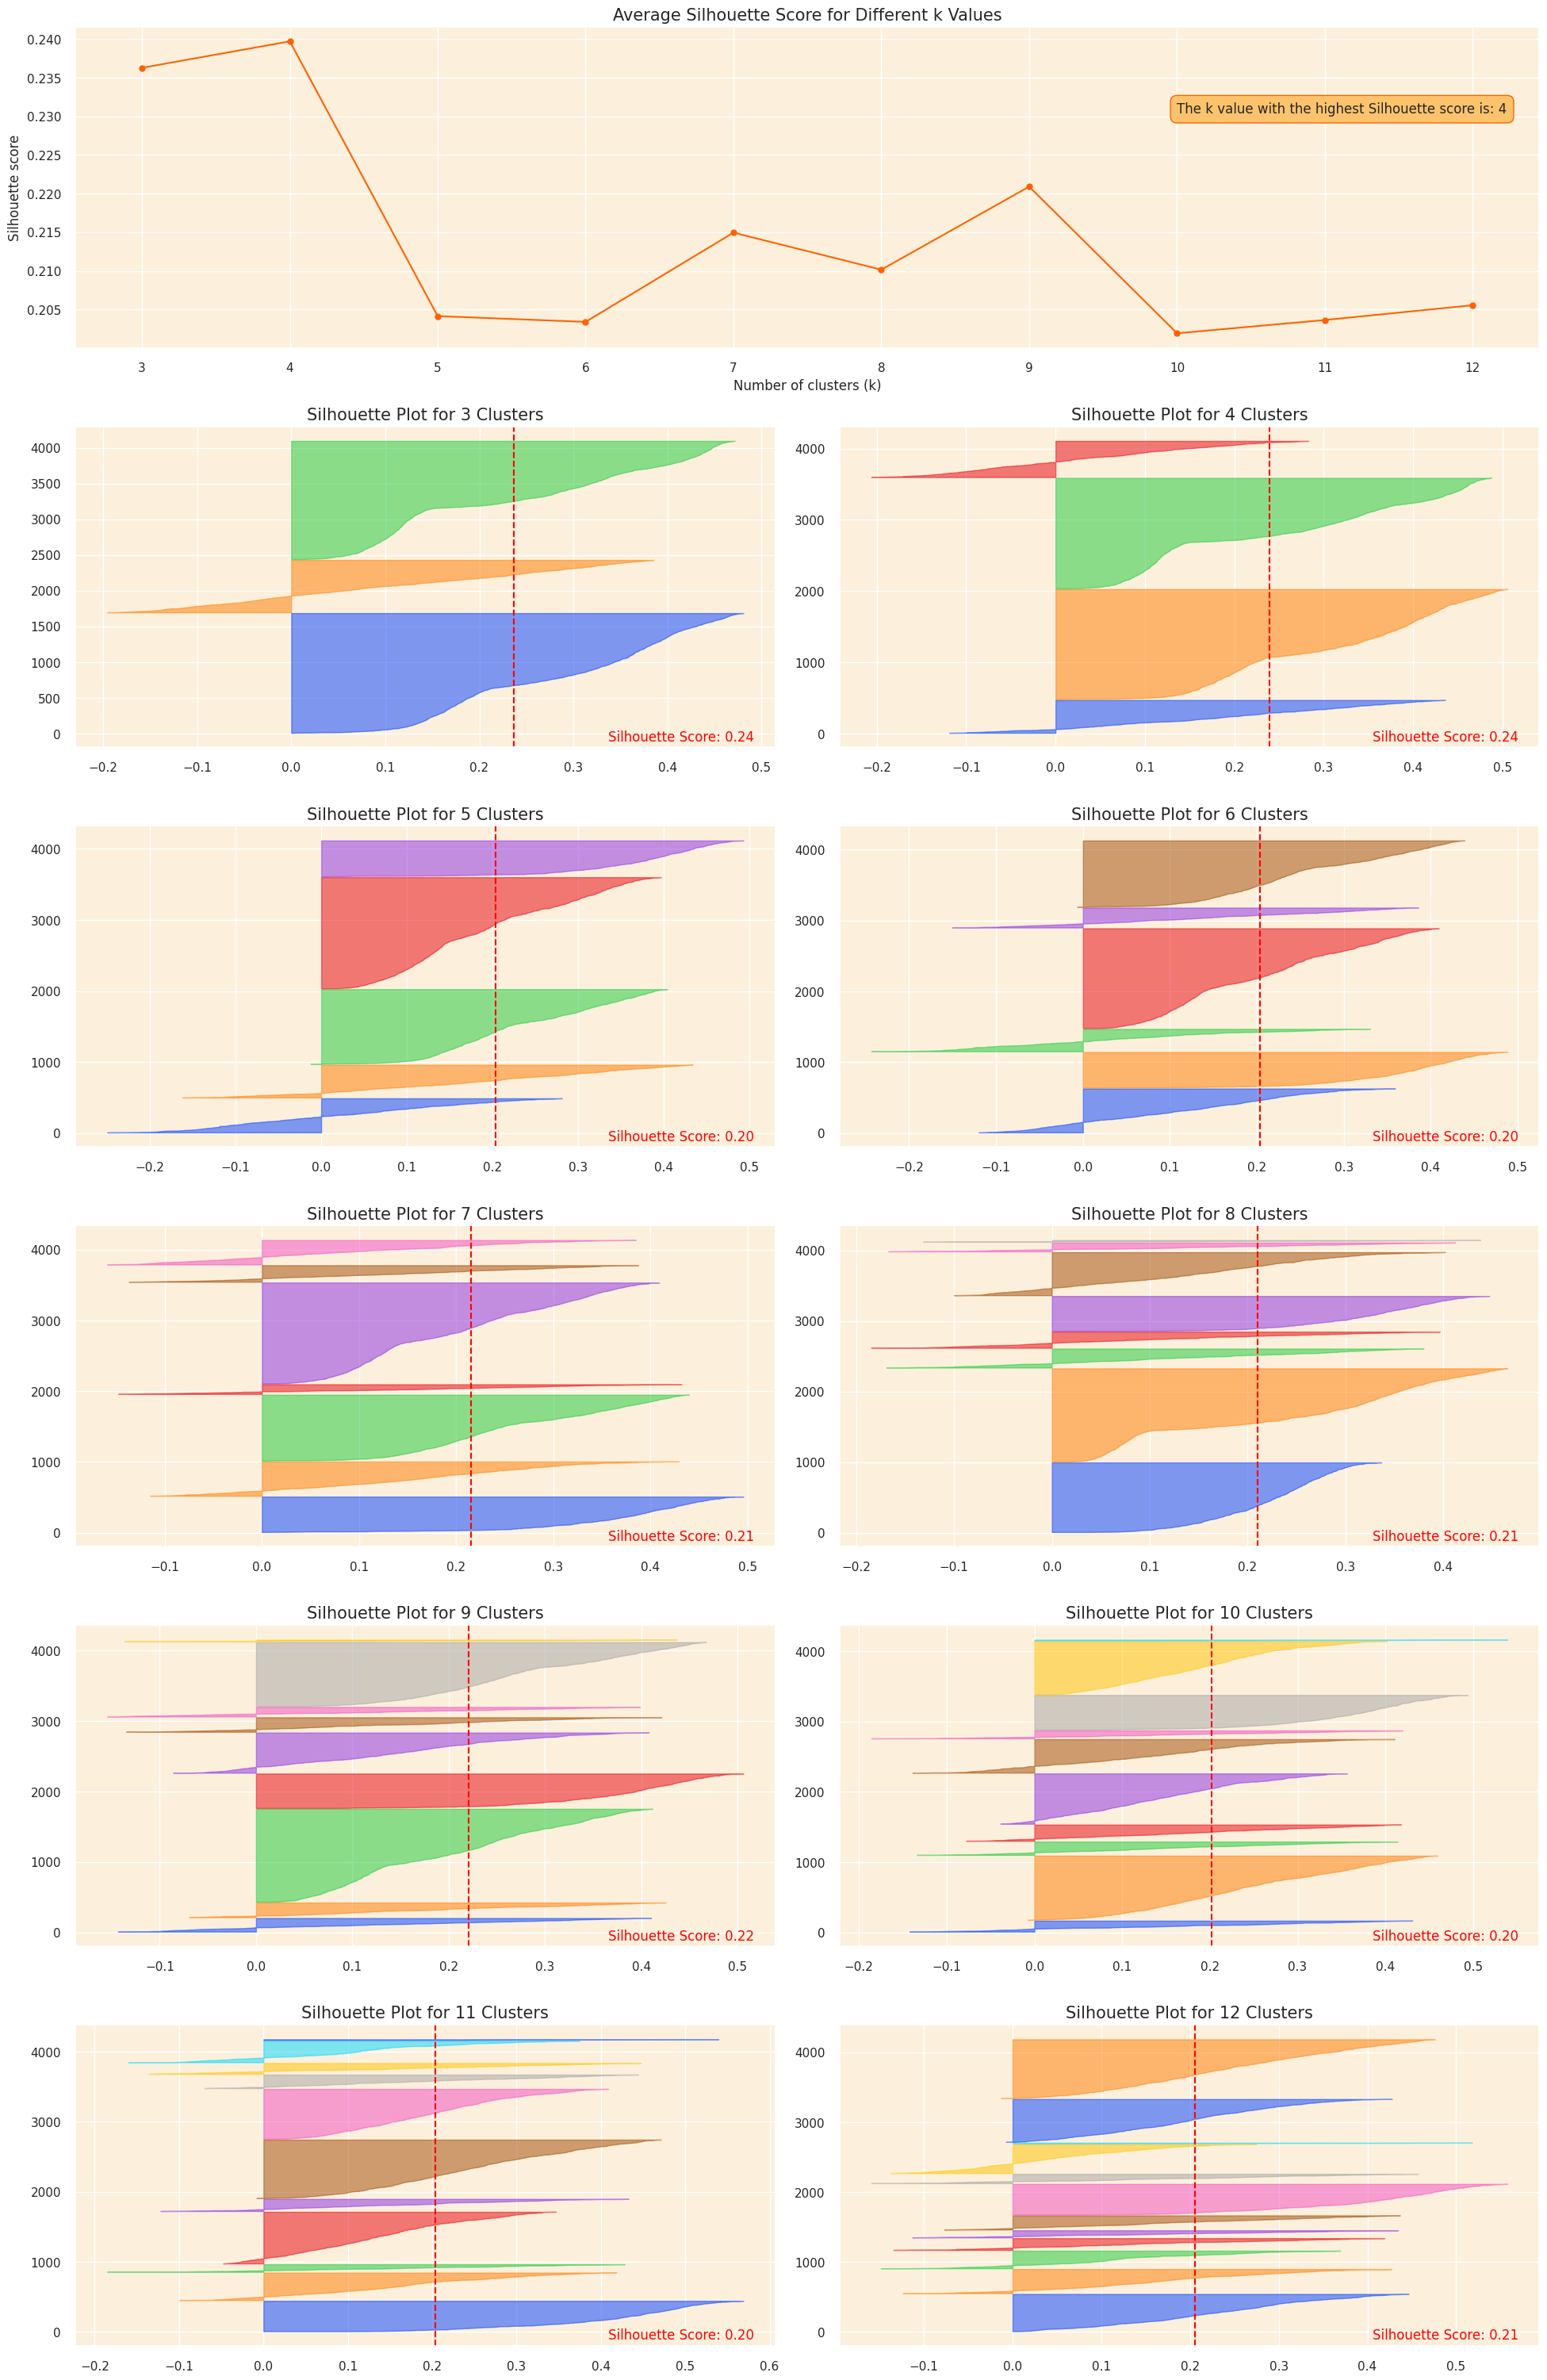

In [61]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

# Silhouett cho K-medoids

In [62]:
def silhouette_analysis1(df, start_k, stop_k, figsize=(15, 16)):
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)
    first_plot = plt.subplot(grid[0, :])
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMedoids(n_clusters = k, init='k-medoids++', max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMedoids(n_clusters = i, init='k-medoids++', max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

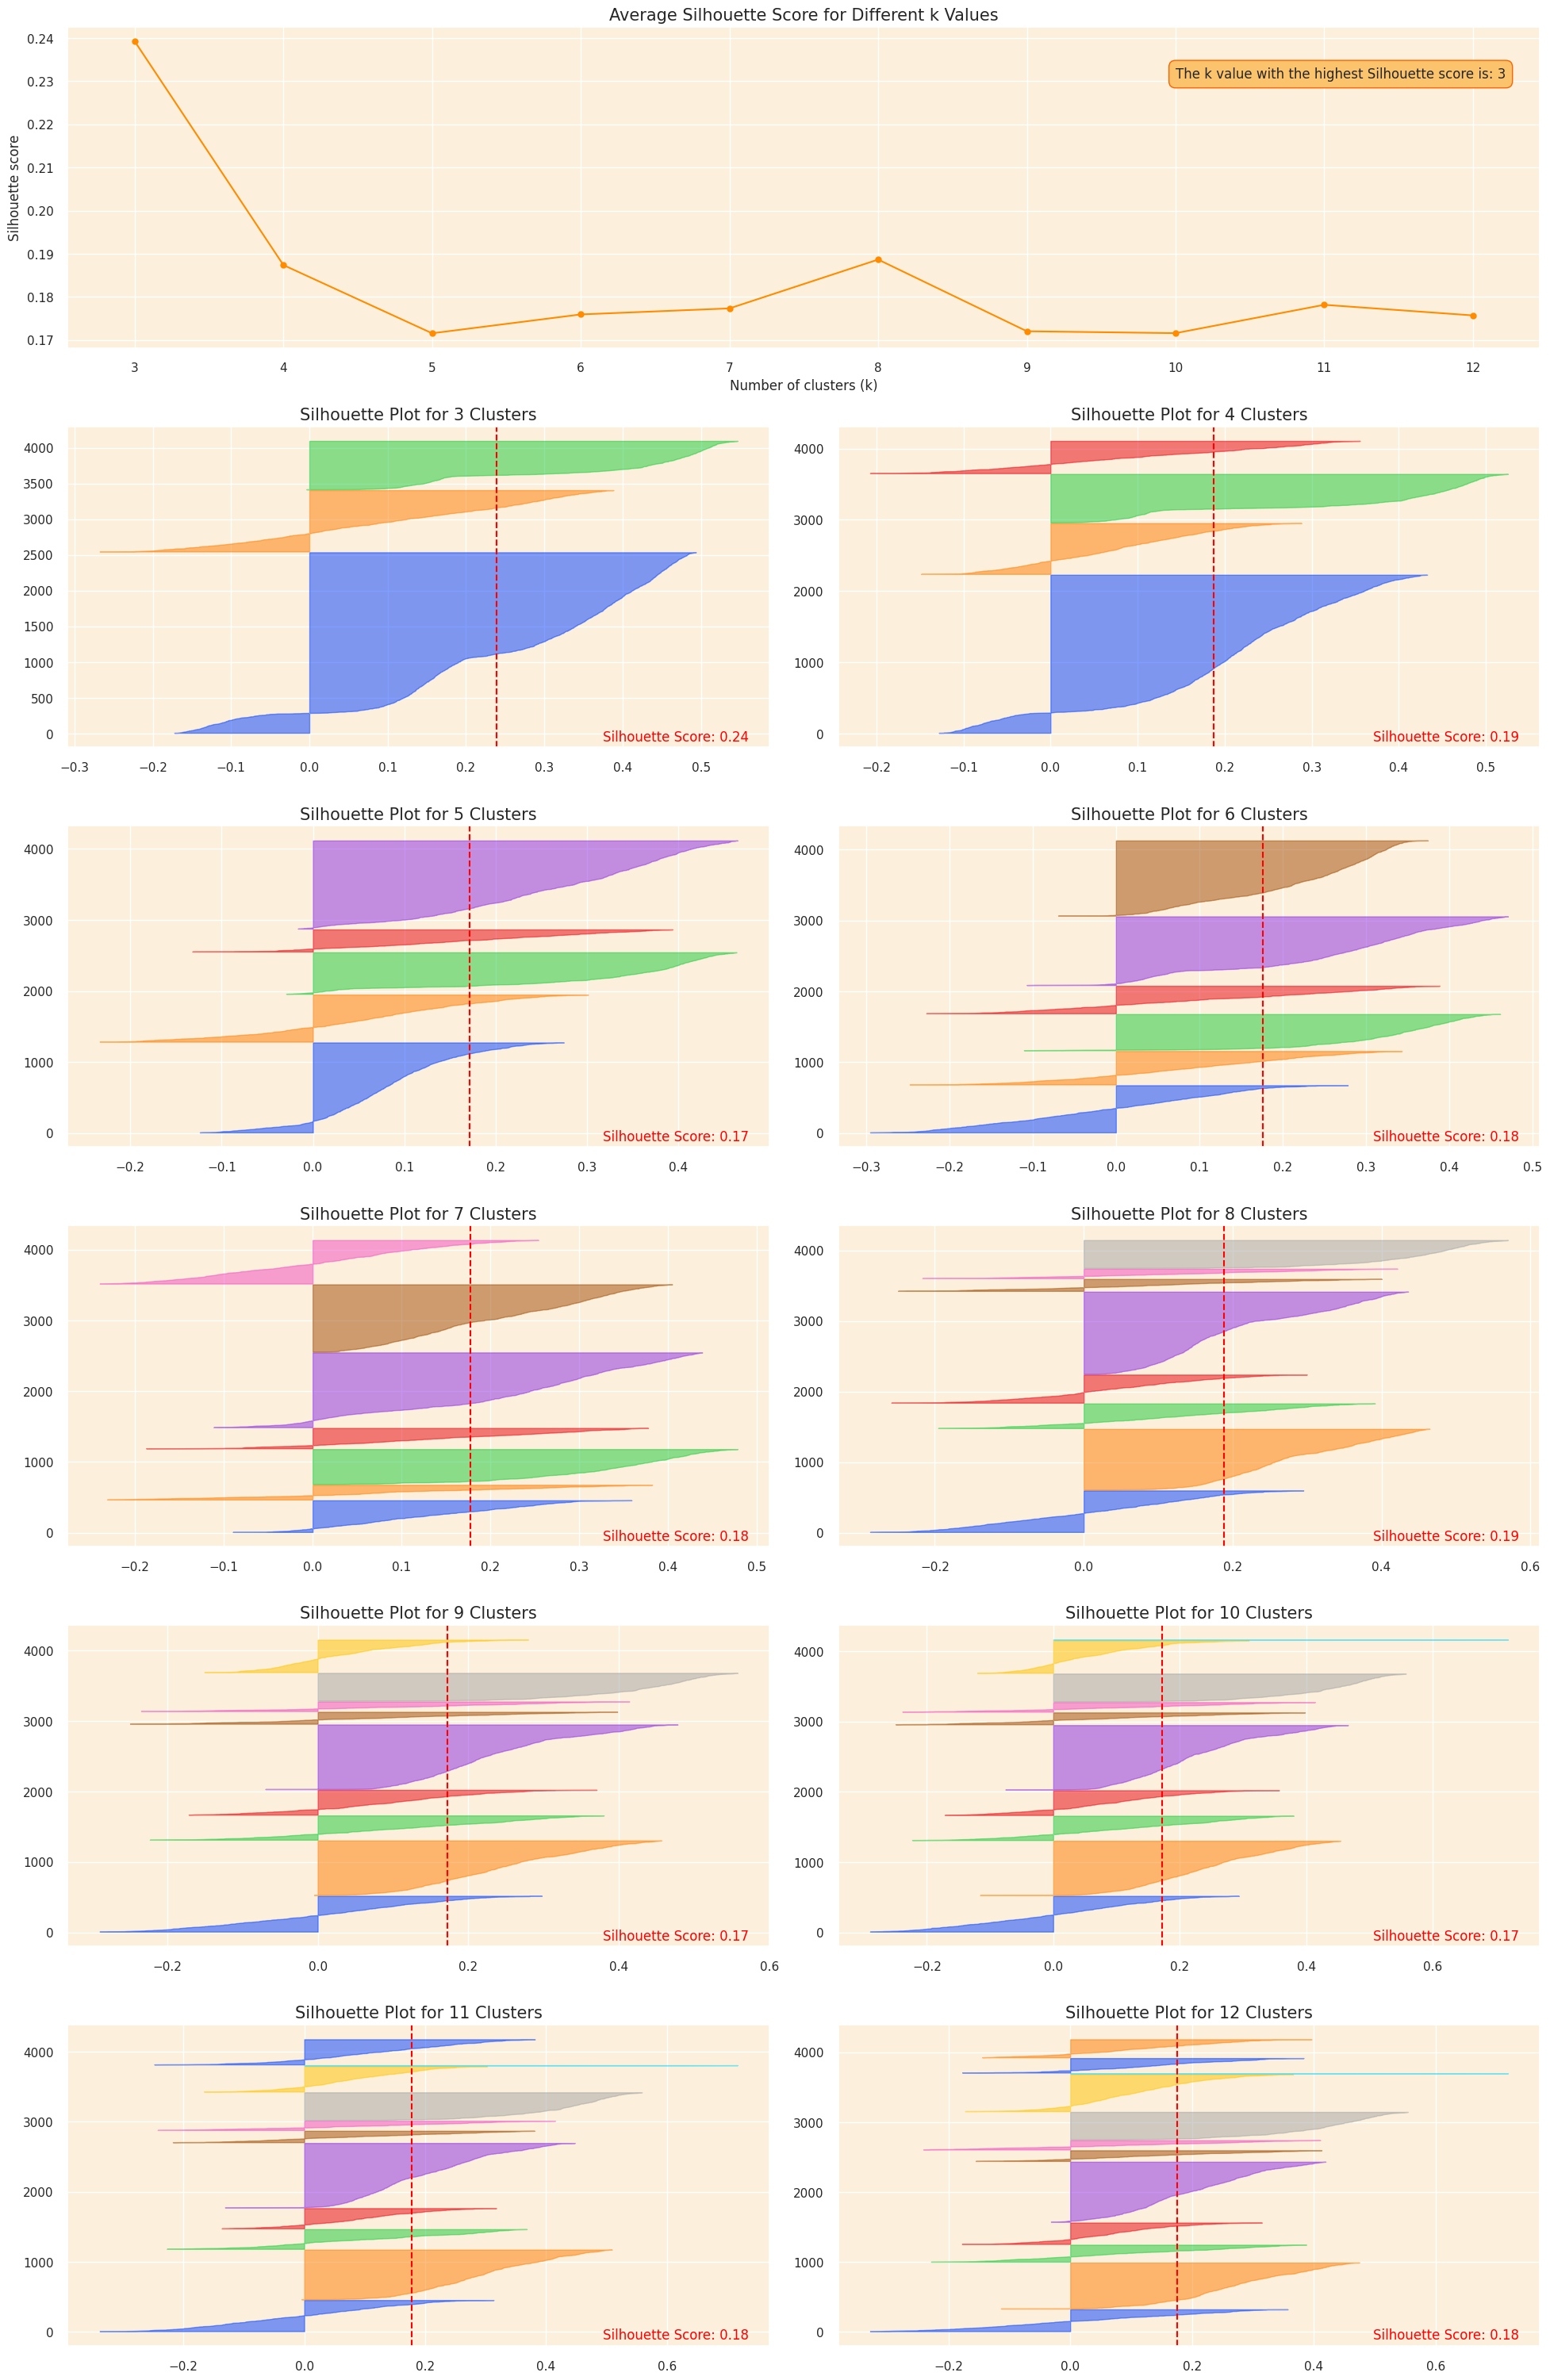

In [63]:
silhouette_analysis1(customer_data_pca, 3, 12, figsize=(20, 50))

# 9.4. Áp dụng K-means

In [64]:
# Âp dụng K-means
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Lấy tần số của mỗi cụm
cluster_frequencies = Counter(kmeans.labels_)

# Tạo ánh xạ từ nhãn cũ sang nhãn mới dựa trên tần suất
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

#Đảo ngược ánh xạ để gán nhãn theo tiêu chí của bạn
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# áp dụng để ra nhãn mới
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Thêm nhãn cụm mới trở lại tập dữ liệu gốc
customer_data_cleaned['cluster'] = new_labels

# Thêm nhãn cụm mới vào phiên bản PCA của tập dữ liệu
customer_data_pca['cluster'] = new_labels

In [65]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


# 9.5. Biểu đồ ScatterPlot

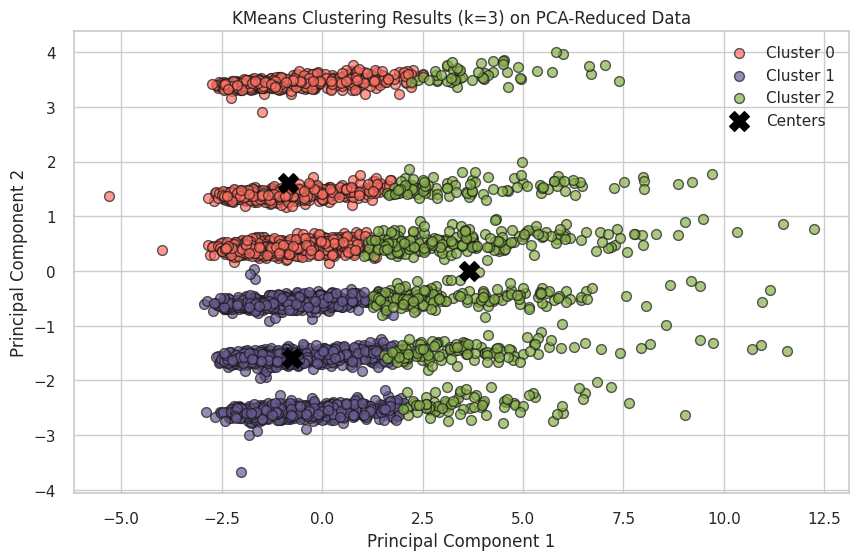

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')
colors = ['#FF6F61', '#6B5B95', '#88B04B']  # Custom colors for clusters

# Plot the data points with distinct colors for each cluster
plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    cluster_data = customer_data_pca[customer_data_pca['cluster'] == i]
    plt.scatter(
        cluster_data.iloc[:, 0], 
        cluster_data.iloc[:, 1], 
        c=color, 
        label=f'Cluster {i}', 
        s=50,  # Size of points
        alpha=0.7,  # Transparency
        edgecolor='k'  # Border for better visibility
    )

# Plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='black', s=200, marker='X', label='Centers'
)

# Add plot details
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Results (k=3) on PCA-Reduced Data')
plt.legend()
plt.show()

In [67]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [68]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()
fig.write_html("3d_cluster_visualization.html")

# 9.5. Biểu đồ cột người dùng

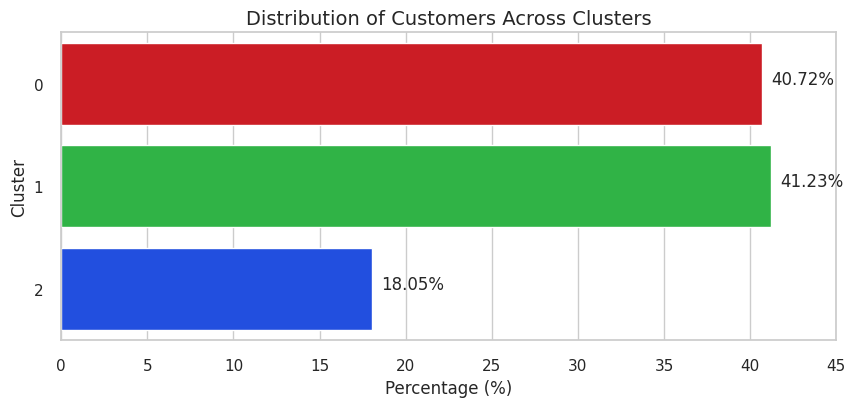

In [69]:
# Tính toán tỷ lệ phần trăm khách hàng trong mỗi cụm
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Tạo một biểu đồ cột ngang
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# 9.6. Sử dụng các thang điểm để đánh giá

In [70]:
# Tính số lượng khách hàng
num_observations = len(customer_data_pca)

# Tách các tính năng và nhãn cụm
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Tính toán các thang điểm
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23627137022779898 |
| Calinski Harabasz Score | 1257.1794962921554  |
|  Davies Bouldin Score   | 1.3684055372996031  |
+-------------------------+---------------------+


# 9.7. Sử dụng biểu đồ radar để đánh giá các nhóm khách hàng

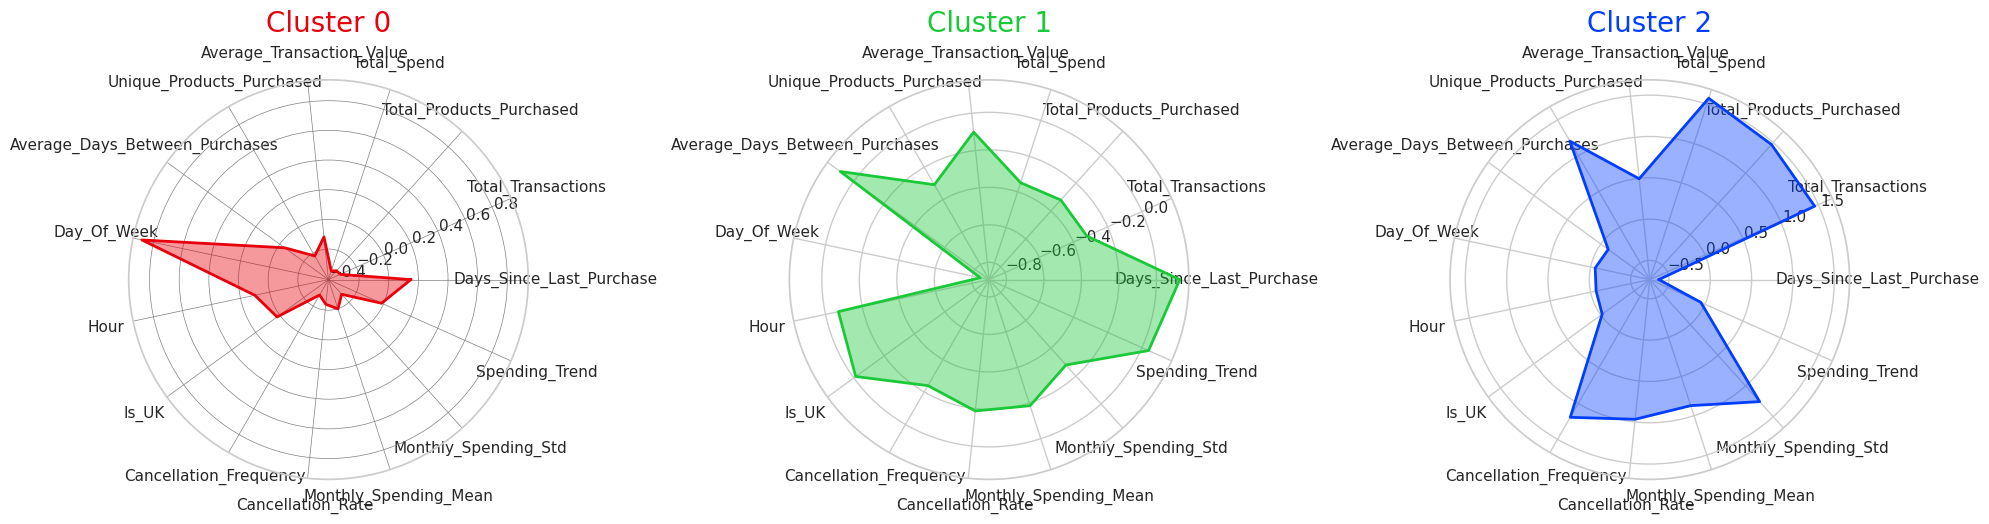

In [71]:
# Đặt cột 'CustomerID' làm chỉ mục và gán nó vào một khung dữ liệu mới
df_customer = customer_data_cleaned.set_index('CustomerID')

# Chuẩn hóa dữ liệu (loại trừ cột cụm)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Tạo một khung dữ liệu mới với các giá trị chuẩn hóa và thêm lại cột cụm
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Tính toán tâm của các cụm
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Chức năng tạo biểu đồ radar
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Biểu đồ là hình tròn, vì vậy cần hoàn thành vòng lặp và thêm phần đầu vào phần cuối
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Tạo radar cho từng cụm
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[0].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

# 10. Làm tương tự với K-medoids

In [72]:
kmedoids = KMedoids(n_clusters=4, init='k-medoids++', max_iter=100, random_state=0)
kmedoids.fit(customer_data_pca)

cluster_frequencies = Counter(kmedoids.labels_)

label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}
label_mapping = {v: k for k, v in {5: 0, 4: 1, 3: 2, 2: 3}.items()}

new_labels = np.array([label_mapping[label] for label in kmedoids.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

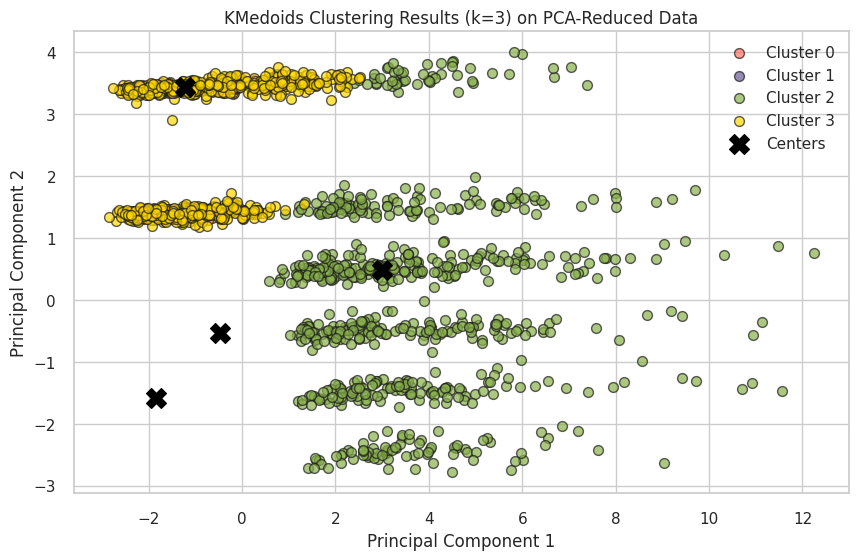

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#FFD700',]  # Custom colors for clusters


plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    cluster_data = customer_data_pca[customer_data_pca['cluster'] == i]
    plt.scatter(
        cluster_data.iloc[:, 0], 
        cluster_data.iloc[:, 1], 
        c=color, 
        label=f'Cluster {i}', 
        s=50,  
        alpha=0.7, 
        edgecolor='k'  
    )


centers = kmedoids.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='black', s=200, marker='X', label='Centers'
)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMedoids Clustering Results (k=3) on PCA-Reduced Data')
plt.legend()
plt.show()

In [74]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,4
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,5
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,5
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,4


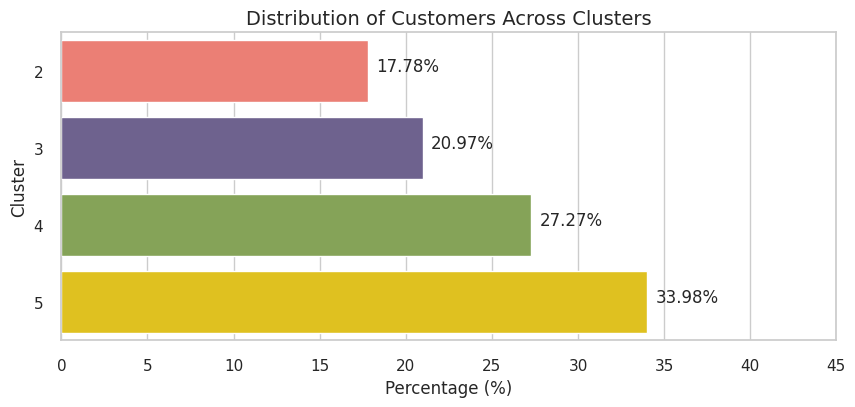

In [75]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')


plt.show()

In [76]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']


sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4067        |
|    Silhouette Score     | 0.1596634872051111 |
| Calinski Harabasz Score | 949.8142503409375  |
|  Davies Bouldin Score   | 1.8372503130133782 |
+-------------------------+--------------------+


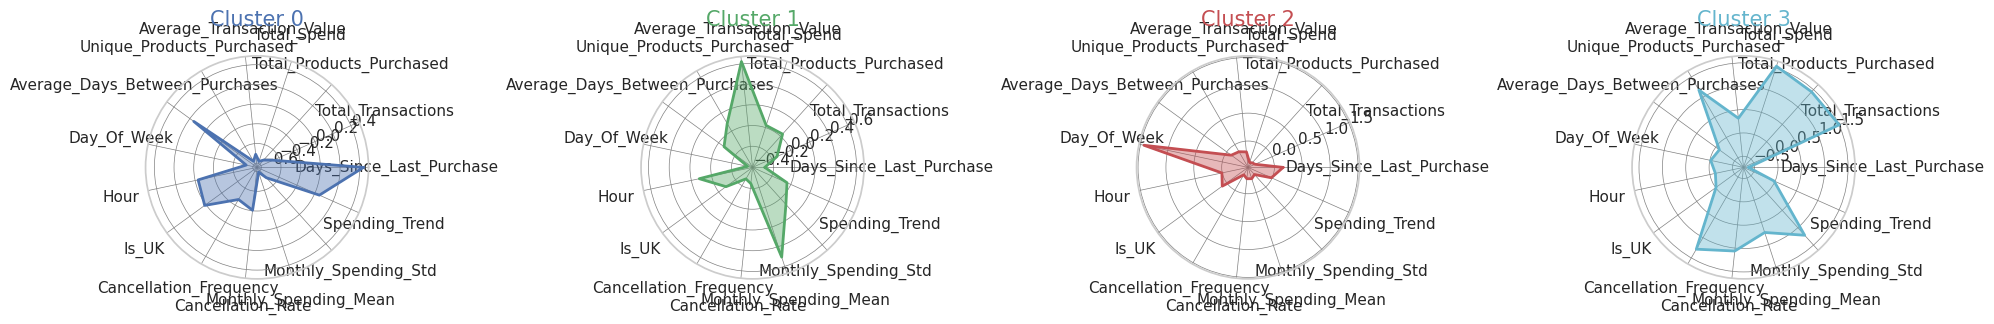

In [77]:
kmedoids = KMedoids(n_clusters=4, init='k-medoids++', max_iter=100, random_state=0)
kmedoids.fit(customer_data_pca)

cluster_frequencies = Counter(kmedoids.labels_)
label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}
new_labels = np.array([label_mapping[label] for label in kmedoids.labels_])

customer_data_cleaned['cluster'] = new_labels
customer_data_pca['cluster'] = new_labels

df_customer = customer_data_cleaned.set_index('CustomerID')
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2)
    ax.set_title(f'Cluster {cluster}', size=15, color=color, y=1.1)

labels = np.array(cluster_centroids.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
labels = np.concatenate((labels, [labels[0]]))

colors = ['b', 'g', 'r', 'c']
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=4)

for i, color in enumerate(colors[:len(cluster_centroids)]):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])
    ax[i].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()